# COMP9418 - Assignment 1 - Bayesian Networks as Classifiers

## UNSW Sydney, October 2020

- Student name 1 - z5272654
- Student name 2 - 

## Technical prerequisites

These are the libraries your are allowed to use. No other libraries will be accepted.

In [1]:
# Make division default to floating-point, saving confusion
from __future__ import division
from __future__ import print_function

# Allowed libraries
import numpy as np
import pandas as pd
import scipy as sp
import heapq as pq
import matplotlib as mp
import math
from collections import defaultdict
from itertools import product, combinations
from collections import OrderedDict as odict
from graphviz import Digraph
from tabulate import tabulate
import copy
import time

## Initial task - Initialise graph

Create a graph ``G`` that represents the following network by filling in the edge lists.
![Bayes Net](BayesNet.png)


In [2]:
G = {
    "BreastDensity" : ["Mass"],
    "Location" : ["BC"],
    "Age" : ["BC"],
    "BC" : ["Metastasis","MC","Mass","SkinRetract","NippleDischarge","AD"],
    "Mass" : ["Size","Shape","Margin"],
    "AD" : ["FibrTissueDev"],
    "Metastasis" : ["LymphNodes"],
    "MC" : [],
    "Size" : [],
    "Shape" : [],
    "FibrTissueDev" : ["NippleDischarge","SkinRetract","Spiculation"],
    "LymphNodes" : [],
    "SkinRetract" : [],
    "NippleDischarge" : [],
    "Spiculation" : ["Margin"],
    "Margin" : [],
}

## [20 Marks] Task 1 - Efficient d-separation test

Implement the efficient version of the d-separation algorithm in a function ``d_separation(G, X, Z, Y)`` that return a boolean: true if **X** is d-separated from **Y** given **Z** in the graph $G$ and false otherwise.

* **X**,**Y** and **Z** are python sets, each containing a set of variable names. 
* Variable names may be strings or integers, and can be assumed to be nodes of the graph $G$. 
* $G$ is a graph as defined in tutorial 1.

In [3]:
## Develop your code for d_separation(G, X, Z, Y) in one or more cells here
#copy the code from tut1
def dfs_r(G, v, colour):
    colour[v] = 'grey'
    for w in G[v]:
        if colour[w] == 'white':
            dfs_r(G, w, colour)
    colour[v] = 'black'

def dfs(G, start):
    colour = {node: 'white' for node in G.keys()}
    dfs_r(G, start, colour)
    return colour

def d_separation(G,X,Z,Y):
# 1. We delete any leaf node W from DAG G as long as W does not belong to X ∪ Y ∪ Z. This process is
# repeated until no more nodes can be deleted.
    set_union = X.union(Z,Y)
    G_prime = copy.deepcopy(G)
    k_list = []
    for k in G_prime.keys():
        k_list.append(k)
    for k in k_list:
        if not G_prime[k] and k not in set_union:
            del G_prime[k]
    for k in G_prime.keys():
        for item in G_prime[k]:
            if item not in G_prime.keys():
                G_prime[k].remove(item)
#2.We delete all edges outgoing from nodes in Z.

    for node in Z:
        G_prime[node]=[]

#Depth_first search
    for i in set(X):
        color = dfs(G, i)
        for j in set(Y):
            if color[j] == 'black':
                return True
    return False

In [4]:
############
## TEST CODE

def test(statement):
    if statement:
        print("Passed test case")
    else:
        print("Failed test case")
        
test(d_separation(G, set(['Age']), set(['BC']), set(['AD'])))
test(not d_separation(G, set(['Spiculation','LymphNodes']), set(['MC', 'Size']), set(['Age'])))

Passed test case
Passed test case


## [10 Marks] Task 2 - Estimate Bayesian Network parameters from data

Implement a function ``learn_outcome_space(data)`` that learns the outcome space (the valid values for each variable) from the pandas dataframe ``data`` and returns a dictionary ``outcomeSpace`` with these values.

Implement a function ``learn_bayes_net(G, data, outcomeSpace)`` that learns the parameters of the Bayesian Network $G$. This function should return a dictionary ``prob_tables`` with the all conditional probability tables (one for each node).

- ``G`` is a directed acyclic graph. For this part of the assignment, $G$ should be declared according to the breast cancer Bayesian network presented in the diagram in the assignment specification.
- ``data`` is a dataframe created from a csv file containing the relevant data. 
- ``outcomeSpace`` is defined in tutorials.
- ``prob_tables`` is a dict from each variable name (node) to a "factor". Factors are defined in tutorial 2. 

In [5]:
## Develop your code for learn_outcome_space(data) in one or more cells here
def learn_outcome_space(data):
    result = {}
    for i in set(data.columns):
        result[i] = list(set(data[i]))
    return result

In [6]:
############
## TEST CODE

with open('bc.csv') as file:
    data = pd.read_csv(file)


outcomeSpace = learn_outcome_space(data)

outcomes = outcomeSpace['BreastDensity']
answer = ('high', 'medium', 'low')
test(len(outcomes) == len(answer) and set(outcomes) == set(answer))


Passed test case


In [7]:
## Develop your code for learn_bayes_net(G, data, outcomeSpace) in one or more cells here
def allEqualThisIndex(dict_of_arrays, **fixed_vars):
    # base index is a boolean vector, everywhere true
    first_array = dict_of_arrays[list(dict_of_arrays.keys())[0]]
    index = np.ones_like(first_array, dtype=np.bool_)
    for var_name, var_val in fixed_vars.items():
        index = index & (np.asarray(dict_of_arrays[var_name])==var_val)
    return index

def estProbTable(data, var_name, parent_names, outcomeSpace):
    var_outcomes = outcomeSpace[var_name]
    parent_outcomes = [outcomeSpace[var] for var in (parent_names)]
    # cartesian product to generate a table of all possible outcomes
    all_parent_combinations = product(*parent_outcomes)

    prob_table = odict()    
    for i, parent_combination in enumerate(all_parent_combinations):
        parent_vars = dict(zip(parent_names, parent_combination))
        parent_index = allEqualThisIndex(data, **parent_vars)
        for var_outcome in var_outcomes:
            var_index = (np.asarray(data[var_name])==var_outcome)
            prob_table[tuple(list(parent_combination)+[var_outcome])] = (var_index & parent_index).sum()/parent_index.sum() 
    return {'dom': tuple(list(parent_names)+[var_name]), 'table': prob_table}

def transposeGraph(G):#exchange the parents and kids node
    GT = dict((v, []) for v in G)
    for v in G:
        for w in G[v]:
            GT[w].append(v)

    return GT

def learn_bayes_net(G, file, outcomeSpace):
    prob_tables = odict()
    graphT = transposeGraph(G)
    for node, parents in graphT.items():
        prob_tables[node] = estProbTable(data, node, parents, outcomeSpace)
    return prob_tables

In [8]:
############
## TEST CODE

prob_tables = learn_bayes_net(G, data, outcomeSpace)
test(abs(prob_tables['Age']['table'][('35-49',)] - 0.2476) < 0.001)
#prob_tables['BC']['dom']


Passed test case


## [20 Marks] Task 3 - Bayesian Network Classification

Design a new function ``assess_bayes_net(G, prob_tables, data, outcomeSpace, class_var)`` that uses the test cases in ``data`` to assess the performance of the Bayesian network defined by ``G`` and ``prob_tables``. Implement the efficient classification procedure discussed in the lectures. Such a function should return the classifier accuracy. 
 * ``class_var`` is the name of the variable you are predicting, using all other variables.
 * ``outcomeSpace`` was created in task 2
 
Remember to remove the variables ``metastasis`` and ``lymphnodes`` from the dataset before assessing the accuracy.

Return just the accuracy:

``acc = assess_bayes_net(G, prob_tables, data, outcomeSpace, class_var)``

In [9]:
## Develop your code for assess_bayes_net(G, prob_tables, data, outcomeSpace, class_var) in one or more cells here


data = data.drop(columns=["Metastasis", "LymphNodes"])

graph = copy.deepcopy(G)
graph.pop("Metastasis")
graph.pop("LymphNodes")
graph["BC"] = ["MC", "Mass", "SkinRetract", "NippleDischarge", "AD"]
pos = int(len(data) * 0.9)
train_data = data[:pos]  # 90%
test_data = data[pos:]  # 10%
# train_data = data_new[:2000]+data_new[4001:]  # 90%
# test_data = data_new[2001:4000]  # 10%
prob_tables1 = learn_bayes_net(graph, train_data, outcomeSpace)

# initlize the parameters
G = graph
prob_tables = prob_tables1
outcomeSpace = learn_outcome_space(data)
class_var = 'BC'


def assess_bayes_net(G, prob_tables, data, outcomeSpace, class_var):

    markov_blanket = set()
    for node in G:
        if class_var in G[node]:
            markov_blanket.add(node)
        if node in G[class_var]:
            markov_blanket.add(node)
            for othernode in G:
                if node in G[othernode]:
                    markov_blanket.add(othernode)
    markov_blanket = list(markov_blanket)
    correct_num = 0

    for i in range(len(data)):
        line = data.iloc[i]
        outcome_output = []
        for outcome in outcomeSpace[class_var]:
            p = 1
            for node in markov_blanket:
                condition = prob_tables[node]['dom']
                attr = []
                for item in condition:
                    if item == class_var:
                        attr.append(outcome)
                    else:
                        attr.append(line[item])

                n = len(attr)
                if n == 1:
                    p = p*prob_tables[node]['table'][attr[0],]
                else:
                    l = []
                    for i in range(n):
                        l.append(attr[i])
                    o = list(prob_tables[node]['table'].items())
                    for i in range(len(o)):
                        if list(o[i][0]) == l:
                            p = p*o[i][1]
            outcome_output.append(p)

        if line[class_var] == outcomeSpace[class_var][outcome_output.index(max(outcome_output))]:
            correct_num += 1
    return correct_num/len(data)
            


In [10]:
############
## TEST CODE


acc = assess_bayes_net(G, prob_tables, data, outcomeSpace, class_var)
acc


0.84225

Develop a function ``cv_bayes_net(G, data, class_var)`` that uses ``learn_outcome_space``, ``learn_bayes_net``and ``assess_bayes_net`` to learn and assess a Bayesian network in a dataset using 10-fold cross-validation. Compute and report the average accuracy over the ten cross-validation runs as well as the standard deviation, e.g.

``acc, stddev = cv_bayes_net(G, data, class_var)``

In [11]:
## Develop your code for cv_bayes_net(G, data, class_var) in one or more cells here
def cv_bayes_net(G, data, class_var):
    acc_list = []
    outcomeSpace = learn_outcome_space(data)
    k = int(len(data)/10) #2000
    
    for i in range(1,11):
        train_data = data[0:(i-1) * k] + data[(i) * k:]
        test_data = data[(i-1) * k:i * k]
        prob_tables = learn_bayes_net(G, train_data, outcomeSpace)
        acc = assess_bayes_net(G, prob_tables, test_data, outcomeSpace, class_var)
        acc_list.append(acc)

    acc_mean = np.mean(acc_list)
    stddev = np.std(acc_list)
    return acc_mean,stddev



In [12]:
############
## TEST CODE

acc, stddev = cv_bayes_net(G, data, 'BC')
acc

0.8422499999999999

## [10 Marks] Task 4 - Naïve Bayes Classification

Design a new function ``assess_naive_bayes(G, prob_tables, data, outcomeSpace, class_var)`` to classify and assess the test cases in a dataset ``data`` according to the Naïve Bayes classifier. To classify each example, use the log probability trick discussed in the lectures. This function should return the accuracy of the classifier in ``data``.

In [19]:
## Develop your code for assess_naive_bayes(G, prob_tables, data, outcomeSpace, class_var) in one or more cells here
def assess_naive_bayes(G, prob_tables, data, outcomeSpace, class_var):
    
    attr = G[class_var]
    length = len(data)
    
    prior_prob = {}
    for outcome in outcomeSpace[class_var]:
        prior_prob[outcome] = np.sum(data[class_var].values == outcome)/length
    
    correct_num = 0
    for i in range(len(data)):
        line = data.iloc[i]
        outcome_output = []
        for cls in outcomeSpace[class_var]:
            p = prior_prob[cls]
            for node in attr:
                if node != class_var:
                    p = p*prob_tables[node]['table'][cls,line[node]]
            p = np.log(p)
            outcome_output.append(p)

        if line[class_var] == outcomeSpace[class_var][outcome_output.index(max(outcome_output))]:
            correct_num += 1
            
    return correct_num/len(test_data)

In [20]:
############
## TEST CODE

acc = assess_naive_bayes(naive_graph, prob_tables_with_smooth, test_data, outcomeSpace, 'BC')
acc

0.802

Develop a new function ``cv_naive_bayes(data, class_var)`` that uses ``assess_naive_bayes`` to assess the performance of the Naïve Bayes classifier in a dataset ``data``. To develop this code, perform the following steps:

1. Use 10-fold cross-validation to split the data into training and test sets.

2. Implement a function ``learn_naive_bayes_structure(outcomeSpace, class_var)`` to create and return a Naïve Bayes graph structure from ``outcomeSpace`` and ``class_var``. 

3. Use ``learn_bayes_net(G, data, outcomeSpace)`` to learn the Naïve Bayes parameters from a training set ``data``. 

4. Use ``assess_naive_bayes(G, prob_tables, data, outcomeSpace, class_var)`` to compute the accuracy of the Naïve Bayes classifier in a test set ``data``. Remember to remove the variables ``metastasis`` and ``lymphnodes`` from the dataset before assessing the accuracy.

Do 10-fold cross-validation, same as above, and return ``acc`` and ``stddev``.

In [15]:
## Develop your code for learn_naive_bayes_structure(outcomeSpace, class_var) in one or more cells here
def estProbTable_with_smoothing(data, var_name, parent_names, outcomeSpace):
    var_outcomes = outcomeSpace[var_name]
    parent_outcomes = [outcomeSpace[var] for var in (parent_names)]
    # cartesian product to generate a table of all possible outcomes
    all_parent_combinations = product(*parent_outcomes)

    prob_table = odict()    
    for i, parent_combination in enumerate(all_parent_combinations):
        parent_vars = dict(zip(parent_names, parent_combination))
        parent_index = allEqualThisIndex(data, **parent_vars)
        for var_outcome in var_outcomes:
            var_index = (np.asarray(data[var_name])==var_outcome)
            prob_table[tuple(list(parent_combination)+[var_outcome])] = ((var_index & parent_index).sum()+1)/(parent_index.sum() *2)
    return {'dom': tuple(list(parent_names)+[var_name]), 'table': prob_table}

def learn_bayes_net_with_smoothing(G, file, outcomeSpace):
    prob_tables = odict()
    graphT = transposeGraph(G)
    for node, parents in graphT.items():
        prob_tables[node] = estProbTable_with_smoothing(data, node, parents, outcomeSpace)
    return prob_tables

def learn_naive_bayes_structure(outcomeSpace, class_var):
    grpah = defaultdict(list)
    graph[class_var] = []
    for node in outcomeSpace.keys():
        if node == class_var:
            continue
        else:
            grpah[class_var].append(node)
            grpah[node] = []
    return grpah



In [16]:
############
## TEST CODE

naive_graph = learn_naive_bayes_structure(outcomeSpace, 'BC')
#naive_graph

In [17]:
prob_tables_with_smooth = learn_bayes_net_with_smoothing(naive_graph, train_data, outcomeSpace)
prob_tables

OrderedDict([('BreastDensity',
              {'dom': ('BreastDensity',),
               'table': OrderedDict([(('medium',), 0.4991),
                            (('low',), 0.19945),
                            (('high',), 0.30145)])}),
             ('Location',
              {'dom': ('Location',),
               'table': OrderedDict([(('LowInQuad',), 0.25075),
                            (('LolwOutQuad',), 0.2511),
                            (('UpInQuad',), 0.25195),
                            (('UpOutQuad',), 0.2462)])}),
             ('Age',
              {'dom': ('Age',),
               'table': OrderedDict([(('50-74',), 0.50025),
                            (('>75',), 0.1478),
                            (('35-49',), 0.248),
                            (('<35',), 0.10395)])}),
             ('BC',
              {'dom': ('Location', 'Age', 'BC'),
               'table': OrderedDict([(('LowInQuad', '50-74', 'No'),
                             0.5403481012658228),
                   

In [21]:
## Develop your code for cv_naive_bayes(data, class_var) in one or more cells here
def cv_naive_bayes(data, class_var):
    acc_list = []
    outcomeSpace = learn_outcome_space(data)
    graph = learn_naive_bayes_structure(outcomeSpace,class_var)
    k = int(len(data) / 10)  # 2000

    for i in range(1, 11):
        train_data = data[0:(i - 1) * k] + data[(i) * k:]
        test_data = data[(i - 1) * k:i * k]
        prob_tables = learn_bayes_net(graph, train_data, outcomeSpace)
        acc = assess_bayes_net(graph, prob_tables, test_data, outcomeSpace, class_var)
        acc_list.append(acc)

    acc_mean = np.mean(acc_list)
    stddev = np.std(acc_list)
    return acc_mean, stddev

In [22]:
############
## TEST CODE

acc, stddev = cv_naive_bayes(data, 'BC')
acc

0.7926

## [20 Marks] Task 5 - Tree-augmented Naïve Bayes Classification

Similarly to the previous task, implement a Tree-augmented Naïve Bayes (TAN) classifier and evaluate your implementation in the breast cancer dataset. Design a function ``learn_tan_structure(data, outcomeSpace, class_var)`` to learn the TAN structure (graph) from the ``data`` and returns such a structure.

In [23]:
## Develop your code for learn_tan_structure(data, outcomeSpace, class_var) in one or more cells here
def mi_information(data, ai, aj, cls):
    val_ai = set(data[ai])
    val_aj = set(data[aj])
    val_cls = set(data[cls])
    length = len(data)
    mi_prob = []
    m = 0

    for c in val_cls:
        for i in val_ai:
            for j in val_aj:
                
                arr = data[[ai, aj, cls]].values == [i, j, c]
                acc = 0
                for a in arr:
                    if all(a):
                        acc += 1
                all_paiajc = (acc+1)/(length * 2)
                condition_length = np.sum(data[cls].values == [c])
                
                paiajc = (acc+1)/(condition_length+length)
                
                arr1 = data[[ai, cls]].values == [i, c]
                acc1 = 0
                for a in arr1:
                    if all(a):
                        acc1 += 1
                paic = (acc1+1)/(condition_length+length)
                
                arr2 = data[[aj, cls]].values == [j, c]
                acc2 = 0
                for a in arr2:
                    if all(a):
                        acc2 += 1
                pajc = (acc2 + 1) / (condition_length + length)
                m += all_paiajc * math.log(paiajc / (paic * pajc))
    return -m

def prim(G, s):
    S = {s}
    Q = []
    tree = []
    for e in G[s]:
        pq.heappush(Q, [e[1], s, e[0]])
    while len(Q) > 0:
        [cost, v, u] = pq.heappop(Q)
        if not u in S:
            S.add(u)
            tree.append([v, u, cost])
            for e in G[u]:
                if not e[0] in S:
                    pq.heappush(Q, [e[1], u, e[0]])
    return tree
def learn_tan_structure(data, outcomeSpace, class_var):
    
    attr = list(data.columns)
    attr.remove(class_var)
    length = len(attr)
    maps = {}
    for a in attr:
        maps[a] = []
    for a in attr:
        for b in attr:
            if b != a:
                maps[a].append([b, mi_information(data, a, b, class_var)])
    tree = prim(maps, attr[0])

    tangraph = defaultdict(list)

    for i in attr:
        if i != class_var:
            tangraph[class_var].append(i)
    for edge in tree:
        if edge[0] != class_var:
            tangraph[edge[0]].append(edge[1])
        if edge[1] not in tangraph:
            tangraph[edge[1]] = []
    return tangraph


In [24]:
############
## TEST CODE

tan_graph = learn_tan_structure(train_data, outcomeSpace, class_var)
test(len(tan_graph['BC']) == len(tan_graph)-1)
test('FibrTissueDev' in tan_graph['Spiculation'] or 'Spiculation' in tan_graph['FibrTissueDev'])


Passed test case
Passed test case


Similarly to the other tasks, design a function ``cv_tan(data, class_var)`` that uses 10-fold cross-validation to assess the performance of the TAN classifier from ``data``. Remember to remove the variables ``metastasis`` and ``lymphnodes`` from the dataset before assessing the accuracy. This function should use the ``learn_tan_structure`` as well as other functions defined in this notebook.

In [23]:
# Develop your code for cv_tan(data, class_var) in one or more cells here
def cv_tan(data, class_var):
    acc_list = []
    outcomeSpace = learn_outcome_space(data)
    k = int(len(data) / 10)  # 2000

    for i in range(1, 11):
        train_data = data[0:(i - 1) * k] + data[i * k:]
        
        test_data = data[(i - 1) * k:i * k]
        
        tan_graph = learn_tan_structure(train_data, outcomeSpace, class_var)
        
        prob_tables = learn_bayes_net(tan_graph, train_data, outcomeSpace)
        
        acc = assess_bayes_net(tan_graph, prob_tables, test_data, outcomeSpace, class_var)
        
        acc_list.append(acc)

    acc_mean = np.mean(acc_list)
    stddev = np.std(acc_list)
    return acc_mean, stddev


In [24]:
############
## TEST CODE
starttime = time.time()
acc, stddev = cv_tan(data, 'BC')
endtime = time.time()
print('total time taken:',endtime-starttime)
acc

total time taken: 39.59582853317261


0.7906500000000001

## [20 Marks] Task 6 - Report

Write a report (**with less than 500 words**) summarising your findings in this assignment. Your report should address the following:

a. Make a summary and discussion of the experimental results (accuracy). Use plots to illustrate your results.

b. Discuss the complexity of the implemented algorithms.

Use Markdown and Latex to write your report in the Jupyter notebook. Develop some plots using Matplotlib to illustrate your results. Be mindful of the maximum number of words. Please, be concise and objective.

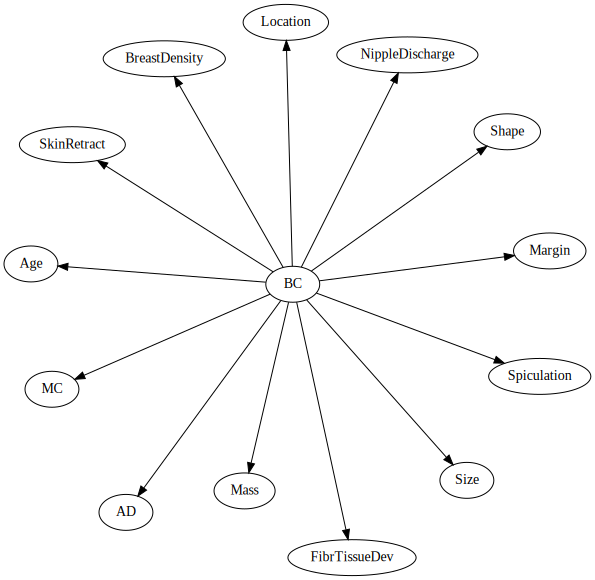

In [31]:
## Develop your report in one or more cells here
def plot_graph(graph):
    dot = Digraph(engine="neato", comment='Direct graph example')
    dot.attr(overlap="false", splines="true")
    
    for v in graph.keys():
        dot.node(v)              
    
    for v in graph.keys():
        for w in graph[v]:
            dot.edge(v,w)
    return dot


dot4 = plot_graph(naive_graph)
dot4


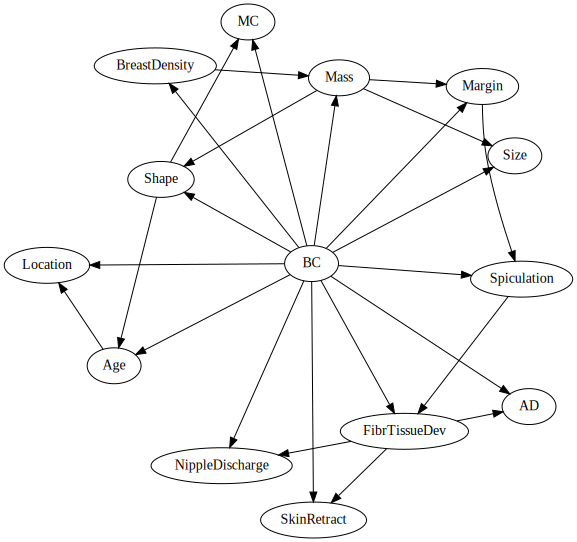

In [32]:
dot5

In [34]:
%%html
<img src="bayes_net.jpg",width=300,height=300>

In [38]:
%%html
<img src="naive_bayes.jpg",width=300,height=300>

In [39]:
%%html
<img src="tan.jpg",width=300,height=300>

  After implementing three classifiers,from my model, I find that Bayes Network has the top-1 accuracy among the three, following by the Naïve Bayes classfier Classification, and tree-augmented Naïve Bayes Classification has the lowest accuracy. The average accuracys of them are 84.2%,79.2% and 79.0% respectively. This is partly not correct.Theoretically, TAN should have the highest accuracy among three.  Maybe there is something wrong with my TAN implement.
  From the coding difficulty, NBC is the easiest one among three, but it has rather poor performance in classification. From the naive bayes graph, we can easily know that every node except the "class variable" is independent(can also learn from the Naïve Bayes assumption).The Bayes Network classfier is a lot more difficult to implement compared to the NBC. In BNC, all the node are discrete, and some of them has strong dependency. Because of this, to assess this classifier from the probability table, I find the markov blanket of node "BC" which make the classification more accurate. Due to this property of BNC, it can learn much causal relationship between the variables, making it strong to avoid overfitting.
  As an expansion of NBC, TAN can learn
 